In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from st_utils import get_gene_type, name_parser
from st_utils import correct_tissue_names
from st_utils import correct_platform_panel
from constants import CORRECT_PLATFORM_PANEL
from constants import SAMPLES,sample_color

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')

year = '2024'


working directory: /Users/whuan/dev/ist_benchmarking


/Users/whuan/opt/anaconda3/envs/sp/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [29]:
# get common genes
samples = []
sample_gene_list = {}
for sample in SAMPLES[:12][::2]:
    print (sample)
    samples.append(sample)
    genes = pd.read_parquet(
        f'{wd}/data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'
        ).columns[2:-2]
    
    filtered_genes = [gene for gene in genes if get_gene_type(gene) == 'gene']
    platform_panel = CORRECT_PLATFORM_PANEL['_'.join(sample.split('_')[-3:-1])]
    sample_gene_list[platform_panel] = filtered_genes

xenium_breast_htma
xenium_panhuman_htma
xenium_lung_htma
merscope_breast_htma
merscope_lung_htma
cosmx_multitissue_htma


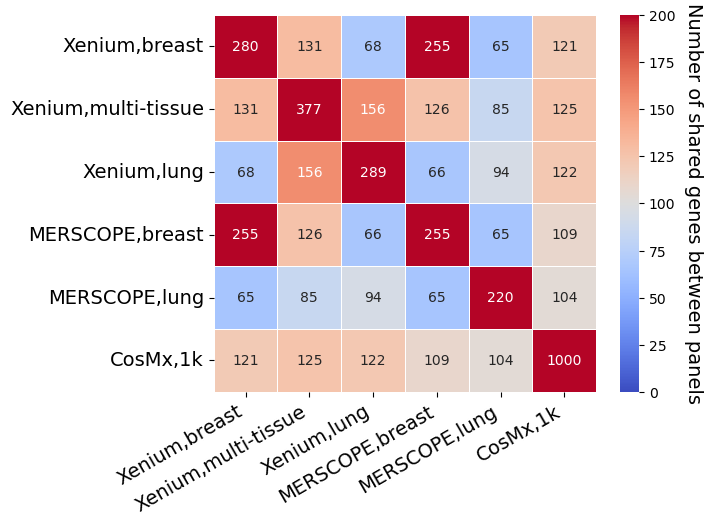

In [30]:
# Create an empty matrix to store the shared gene counts
matrix = []

# Create a list of sample names
sample_names = list(sample_gene_list.keys())

# Calculate shared gene counts and populate the matrix
for sample1 in sample_names:
    row = []
    genes1 = set(sample_gene_list[sample1])
    for sample2 in sample_names:
        genes2 = set(sample_gene_list[sample2])
        shared_genes = len(genes1.intersection(genes2))
        row.append(shared_genes)
    matrix.append(row)

matrix = np.array(matrix)
matrix = matrix+1

# Create the heatmap with annotations
plt.figure(figsize=(8, 5.3))  # Increase the figure width to accommodate the y-axis label
g = sns.heatmap(matrix, annot=True, cmap='coolwarm', linewidths=0.5,
                vmin=0, vmax=200, fmt=".0f", xticklabels=sample_names, yticklabels=sample_names)
cbar = g.collections[0].colorbar

# Adjust the position and size of the colorbar
cbar.ax.set_position([0.91, 0.1, 0.02, 0.77])  # Adjust the first and third values
cbar.ax.set_ylabel(f"Number of shared genes between panels", rotation=270, labelpad=20, fontsize=14)
plt.xlabel('')
plt.ylabel('')

fontsize = 14
xlabels = g.get_xticklabels()
g.set_xticklabels(xlabels, fontsize=fontsize, rotation=30, ha="right")

ylabels = g.get_yticklabels()
g.set_yticklabels(ylabels, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f'{wd}/figures/Fig_1/supp_1_shared_gene.png', dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/Fig_1/supp_1_shared_gene.eps', dpi=250, transparent=True)
plt.show()

# Metric (transcript/cell, unique genes/cell) heatmap

In [31]:
samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)

sample_gene_list = {}

for sample in samples:
    if 'merscope_lung' in sample:
        continue
    print (sample)
    genes = pd.read_parquet(
        f'data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'
        ).columns[2:-2]
    
    sample_gene_list[sample] = genes

common_genes = set(sample_gene_list[samples[0]])
for sample in samples[1:]:
    common_genes &= set(sample_gene_list[sample])
common_genes  = list(common_genes)
print (f'{len(common_genes)} commom genes')

['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']
2024_xenium_breast_htma
2024_xenium_breast_tumor2
2024_merscope_breast_htma
2024_merscope_breast_tumor2
2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2
108 commom genes


In [32]:
if not os.path.exists(f'{wd}/data/single_cell_metrics'):
    os.makedirs(f'{wd}/data/single_cell_metrics')

for common in [False, True]:
    metric = 'transcript_counts'
    cell_by_gene_both = pd.DataFrame()

    df_m = pd.DataFrame()
    for sample in samples:
        # if sample_key1 in SAMPLE or sample_key2 in SAMPLE:
        if 'merscope_lung' in sample:
            continue

        print (sample)
        df_c = pd.read_parquet(
            f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip'
            )[['cell_id','tissue_type','core','transcript_counts']]
        df_c = correct_tissue_names(sample,df_c)
        df_c = df_c.loc[~df_c['cell_id'].str.contains('-1_region')]
        
        df_c = df_c.rename(columns={'transcript_counts':'transcript_counts_given'})
        df_c = df_c.loc[df_c['tissue_type']!='Marker']
        df_c['core'] = df_c['core'].astype(int)

        df_c['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_c['platform'] = name_parser(sample)['platform'].upper()
        df_c['panel'] = name_parser(sample)['panel'].capitalize()
        df_c['tma'] = name_parser(sample)['tma'].upper()
        df_c['platform_panel'] = df_c.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_c['sample'] = sample

        df_c = correct_platform_panel(df_c, 'platform_panel')

        # Convert relevant columns to numeric type
        df_cell_by_gene = pd.read_parquet((f'{wd}/data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'))
        df_cell_by_gene = correct_tissue_names(sample,df_cell_by_gene)
        numeric_cols = df_cell_by_gene.columns.difference(['core', 'tissue_type', 'cell_id']).to_list()

        if common:
            df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+common_genes]  #common genes
            gene_cols = common_genes # or numeric_cols
        else:
            df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+numeric_cols]
            gene_cols = numeric_cols # or numeric_cols   

        df_cell_by_gene1 = df_cell_by_gene.copy()
        df_cell_by_gene1[gene_cols] = df_cell_by_gene1[gene_cols].apply(pd.to_numeric, errors='coerce')
        df_cell_by_gene1[gene_cols] = df_cell_by_gene1[gene_cols].where(df_cell_by_gene1[gene_cols] == 0, 1)
        df_cell_by_gene_sample = df_cell_by_gene1.drop(
            columns=[col for col in df_cell_by_gene1.columns if 'Blank' in col or 'BLANK' in col or 'Neg' in col or 'Sys' in col]
            )
        
        df_cell_by_gene1['unique_genes'] = df_cell_by_gene1.iloc[:, 3:-2].sum(axis=1) # 

        # transcript data
        # df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+numeric_cols.to_list()]
        # df_cell_by_gene = df_cell_by_gene[['core', 'tissue_type', 'cell_id']+common_genes]
        df_cell_by_gene['transcript_counts'] = df_cell_by_gene.iloc[:, 3:].sum(axis=1)

        cell_by_gene_both = pd.concat([cell_by_gene_both, df_cell_by_gene])
        df_c = pd.merge(df_c, df_cell_by_gene[['cell_id','transcript_counts']].reset_index(drop=True), on='cell_id', how='inner')
        df_c = pd.merge(df_c, df_cell_by_gene1[['cell_id','unique_genes']].reset_index(drop=True), on='cell_id', how='inner')
        df_m = pd.concat([df_m,df_c])


    if common:
        df_m.to_parquet(f'{wd}/data/single_cell_metrics/all_cell_level_common_genes_{year}.parquet.gzip', compression='gzip', index=False)
    else:
        df_m.to_parquet(f'{wd}/data/single_cell_metrics/all_cell_level_{year}.parquet.gzip', compression='gzip', index=False)


2024_xenium_breast_htma
2024_xenium_breast_tumor2
2024_merscope_breast_htma
2024_merscope_breast_tumor2
2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2
2024_xenium_breast_htma
2024_xenium_breast_tumor2
2024_merscope_breast_htma
2024_merscope_breast_tumor2
2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2


['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']
year 2024, share genes only False

before QC: 1411952
after QC using transcript count per cell: 1153855
after QC using unique genes per cell: 1153855
Good quality cells: 81.7


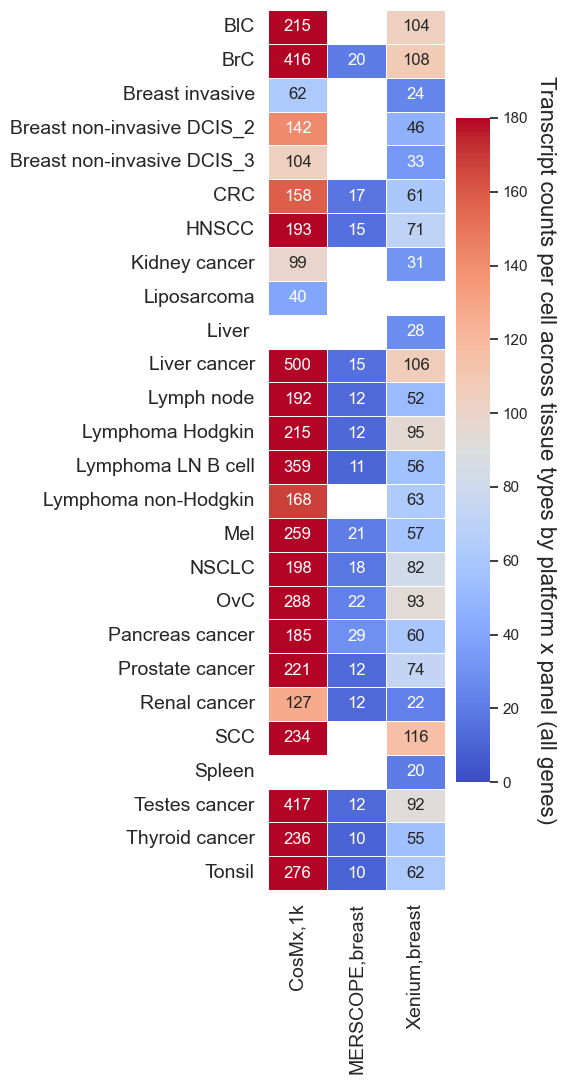

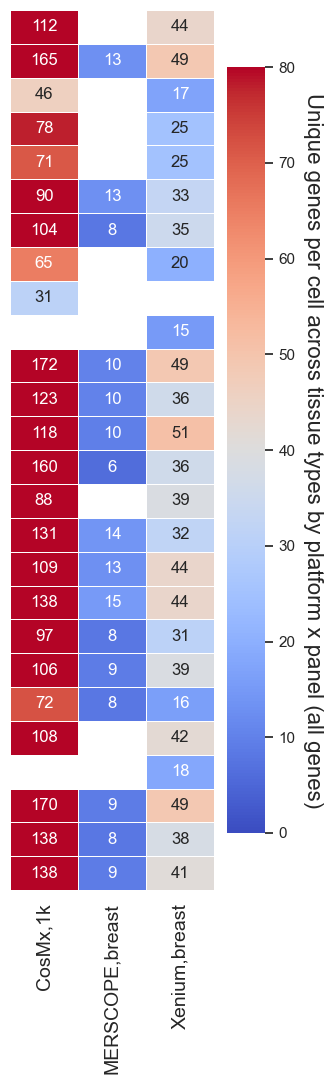

year 2024, share genes only True


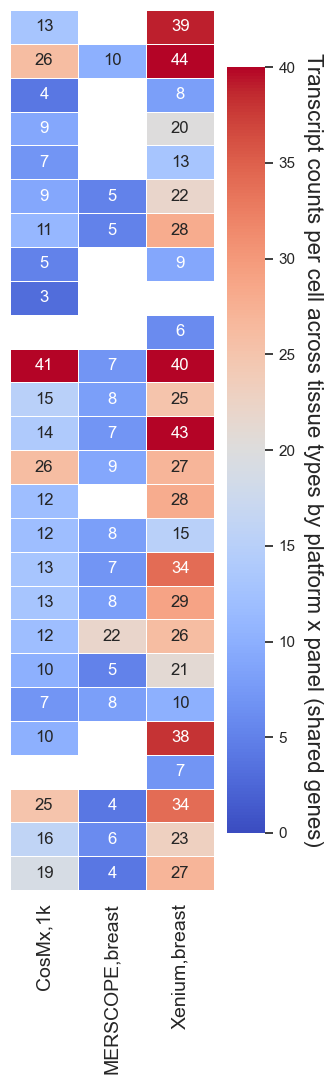

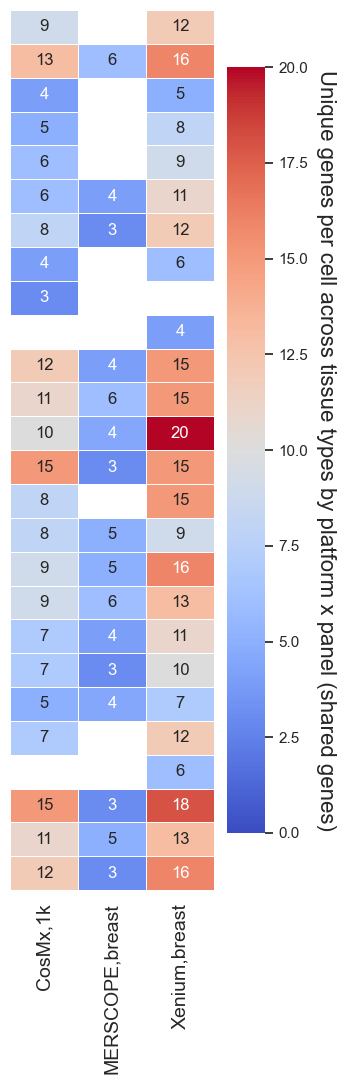

In [104]:
if not os.path.exists(f'{wd}/figures/Fig_4_Segmentation'):
    os.makedirs(f'{wd}/figures/Fig_4_Segmentation')


group_by = 'platform_panel' # platform_panel, sample

for year in ['2024']:

    if year == '2024':
        samples = [x for x in SAMPLES if '2024' in x]
    elif year == '2023':
        samples = [x for x in SAMPLES if '2024' not in x]
    else:
        samples = [x for x in SAMPLES]
    print (samples)

    for common in [False, True]:
        print (f"year {year}, share genes only {common}")
        if common:
            df_m = pd.read_parquet(f'{wd}/data/single_cell_metrics/all_cell_level_common_genes_{year}.parquet.gzip', engine='pyarrow')
            with open(f"{wd}/data/{year}_qced_cell_id", "rb") as fp:
                qced_cell_id = pickle.load(fp)
            df_mat = df_m.copy()
            df_mat['sample_cell_id'] = df_mat['sample'] + "_" + df_mat['cell_id']
            df_mat = df_mat.loc[df_mat['sample_cell_id'].isin(qced_cell_id)]
        else:
            df_m = pd.read_parquet(f'{wd}/data/single_cell_metrics/all_cell_level_{year}.parquet.gzip', engine='pyarrow')

            df_m = df_m.loc[~df_m['cell_id'].str.contains('-1_region') 
                            & ~df_m['tissue_type'].isin(['Renal pelvis'])]

            df_m = df_m.loc[df_m['sample'].isin(samples)]

            metric = 'transcript_counts'
            qc_count_threshold = 10
            qc_unique_gene_threshold = 0

            df_mat = df_m.copy()
            print (f'\nbefore QC: {len(df_mat)}')

            # Same threshold:10
            df_mat = df_mat.loc[df_mat['transcript_counts'] >= qc_count_threshold]

            # Different threshold: 10 for Xenium and MERSCOPE, 20 for CosMx
            df_mat = df_mat.loc[~((df_mat['platform'] == 'COSMX') & (df_mat['transcript_counts'] <= 20))]

            print (f'after QC using transcript count per cell: {len(df_mat)}')
            df_mat = df_mat.loc[df_mat['unique_genes'] >= qc_unique_gene_threshold]
            print (f'after QC using unique genes per cell: {len(df_mat)}')

            print (f'Good quality cells: {round(len(df_mat) * 100/len(df_m),1)}')
            df_mat['sample_cell_id'] = df_mat['sample'] + "_" + df_mat['cell_id']
            qced_cell_id = df_mat.sample_cell_id.to_list()
            with open(f"{wd}/data/{year}_qced_cell_id", "wb") as fp:
                pickle.dump(qced_cell_id, fp)

        for metric in ['transcript_counts', 'unique_genes']:
            df_plot = df_mat.groupby(by=[group_by, 'tissue_type'], as_index=False).agg({metric:'median'})
            df_plot = df_plot.pivot_table(index='tissue_type',columns=group_by,values=metric)
            # display(get_df_color(df_plot))


            vmax = 80 if metric == 'unique_genes' else 180
            figsize=(3.6, 11)  if metric == 'unique_genes' else (6, 11)

            if common:
                vmax = 40
                figsize=(3.6, 11)
                
                if metric == 'unique_genes':
                    vmax = 20

            # Create the heatmap with annotations
            plt.figure(figsize=figsize)  # Increase the figure width to accommodate the y-axis label

            df_plot_trim = df_plot
            if 'MERSCOPE,lung' in df_plot_trim.columns:
                df_plot_trim = df_plot.drop(columns=['MERSCOPE,lung'])
            df_plot_trim = round(df_plot_trim,2)
            g = sns.heatmap(df_plot_trim, annot=True, cmap='coolwarm', linewidths=0.5,
                            vmin=0, vmax=vmax, fmt=".0f")
            cbar = g.collections[0].colorbar
            
            gene_string = 'shared genes' if common else 'all genes'

            # Adjust the position and size of the colorbar
            cbar.ax.set_position([0.91, 0.1, 0.02, 0.77])  # Adjust the first and third values
            cbar.ax.set_ylabel(f"{' '.join(metric.split('_')).capitalize()} per cell across tissue types by platform x panel ({gene_string})", rotation=270, labelpad=20, fontsize=16)
            plt.xlabel('')
            plt.ylabel('')
            fontsize = 14
            xlabels = g.get_xticklabels()
            g.set_xticklabels(xlabels, fontsize=fontsize, rotation=90)
            ylabels = g.get_yticklabels()

            if metric == 'unique_genes' or common==True:
                g.set_yticklabels([])
            else:
                g.set_yticklabels(ylabels, fontsize=fontsize)
        
            plt.tight_layout()
   
            plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_{metric}_{year}_{common}.png', dpi=250, transparent=True)
            plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_{metric}_{year}_{common}.eps', dpi=250, transparent=True)
            plt.show()


In [35]:
df_all = pd.DataFrame()

for sample in samples:
    df_c = pd.read_parquet(
        f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip'
        )
    
    df_c = df_c.loc[~df_c['cell_id'].str.contains('-1_region')]
    pas = []
    transcript_thresholds = []
    for i in range(0,21,1):
        transcript_thresholds.append(i)
        pa = round(len(df_c.loc[df_c['transcript_counts'] >= i]) * 100 /len(df_c),2)
        pas.append(pa)

    df = pd.DataFrame({'transcript_threshold':transcript_thresholds, 'percentage':pas})
    df['Sample'] = sample
    df_all = pd.concat([df_all, df])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


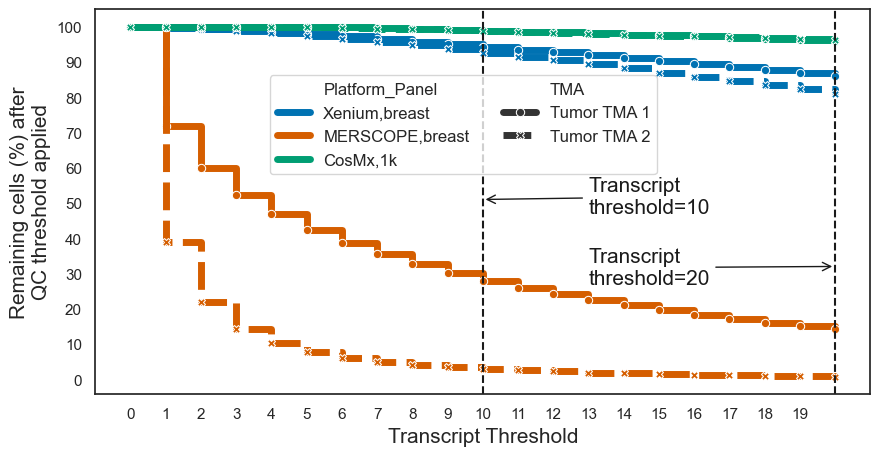

In [77]:
df_plot= df_all.copy()

df_plot['TMA'] = df_plot['Sample'].apply(lambda x: f"{x.split('_')[-1].upper()}")
df_plot['TMA'] = df_plot['TMA'].apply(lambda x: {'HTMA':'Tumor TMA 1','TUMOR2':'Tumor TMA 2'}[x])
df_plot['Platform_Panel'] = df_plot['Sample'].apply(lambda x: f"{x.split('_')[-3].upper()}_{x.split('_')[-2].capitalize()}")
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')


custom_color_dict = {}
for platform_panel in df_plot['Platform_Panel'].unique():
    custom_color_dict[platform_panel] = sample_color[platform_panel]

fontsize = 15
plt.figure(figsize=(10, 5))
sns.set_theme(style="white")
ax = sns.lineplot(data=df_plot, 
             x='transcript_threshold', 
             y='percentage', 
             hue='Platform_Panel',
             drawstyle='steps-post', 
             palette = custom_color_dict,
             style='TMA',
             markers=True,
             linewidth = 5,
             ci=None)
threshold = 10
ax.axvline(x=threshold, color='k', linestyle='--')
ax.axvline(x=20, color='k', linestyle='--')
plt.annotate(f'Transcript\nthreshold={threshold}', xy=(10, 51), xytext=(13, 47),
             arrowprops=dict(arrowstyle='->', color='k'),
             fontsize=fontsize, color='k')

plt.annotate(f'Transcript\nthreshold=20', xy=(20, 32), xytext=(13, 27),
             arrowprops=dict(arrowstyle='->', color='k'),
             fontsize=fontsize, color='k')

x_ticks = np.arange(df_all['transcript_threshold'].min(), df_all['transcript_threshold'].max(), 1)
y_ticks = np.arange(0, 110, 10)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlabel('Transcript Threshold', fontsize=fontsize)
plt.ylabel('Remaining cells (%) after\nQC threshold applied', fontsize=fontsize)
plt.legend(bbox_to_anchor=(0.475, 0.7), loc='center',ncol=2,borderaxespad=0., fontsize=fontsize-3)
plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4D_filtration.png', bbox_inches='tight', dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4D_filtration.eps', bbox_inches='tight', dpi=250, transparent=True)
plt.show()

In [50]:
for i in [10,20]:
    df_plot_selected = df_plot.loc[df_plot['transcript_threshold'].isin([i])]
    df_plot_selected = df_plot_selected.rename(columns={'transcript_threshold':'Transcript Threshold','percentage':'Good Cells (%)'})
    df_plot_selected['TMA'] = df_plot_selected['Sample'].apply(lambda x: x.split('_')[-1].upper())
    df_plot_selected = df_plot_selected.sort_values(by=['Transcript Threshold', 'TMA','Good Cells (%)'], ascending=True)
    df_plot_selected = df_plot_selected[['TMA','Sample','Platform_Panel','Transcript Threshold', 'Good Cells (%)']]
    df_plot_selected.to_csv(f'{wd}/tables/qc{i}.csv', index=False)
    display(df_plot_selected)

,TMA,Sample,Platform_Panel,Transcript Threshold,Good Cells (%)
10,HTMA,2024_merscope_breast_htma,"MERSCOPE,breast",10,27.97
10,HTMA,2024_xenium_breast_htma,"Xenium,breast",10,94.28
10,HTMA,2024_cosmx_multitissue_htma,"CosMx,1k",10,98.89
10,TUMOR2,2024_merscope_breast_tumor2,"MERSCOPE,breast",10,2.98
10,TUMOR2,2024_xenium_breast_tumor2,"Xenium,breast",10,92.66
10,TUMOR2,2024_cosmx_multitissue_tumor2,"CosMx,1k",10,98.74


,TMA,Sample,Platform_Panel,Transcript Threshold,Good Cells (%)
20,HTMA,2024_merscope_breast_htma,"MERSCOPE,breast",20,14.12
20,HTMA,2024_xenium_breast_htma,"Xenium,breast",20,86.04
20,HTMA,2024_cosmx_multitissue_htma,"CosMx,1k",20,95.97
20,TUMOR2,2024_merscope_breast_tumor2,"MERSCOPE,breast",20,0.71
20,TUMOR2,2024_xenium_breast_tumor2,"Xenium,breast",20,81.04
20,TUMOR2,2024_cosmx_multitissue_tumor2,"CosMx,1k",20,96.30


In [51]:
df_plot_selected = df_plot.loc[df_plot['transcript_threshold']==20]
df_plot_selected = df_plot_selected.rename(columns={'transcript_threshold':'Transcript Threshold','percentage':'Good Cells (%)'})
df_plot_selected['TMA'] = df_plot_selected['Sample'].apply(lambda x: x.split('_')[-1].upper())
df_plot_selected = df_plot_selected.sort_values(by=['TMA','Transcript Threshold', 'Good Cells (%)'], ascending=False)
df_plot_selected = df_plot_selected[['TMA','Sample','Platform_Panel','Transcript Threshold', 'Good Cells (%)']]
df_plot_selected.to_csv(f'{wd}/tables/qc_20.csv', index=False)
df_plot_selected

,TMA,Sample,Platform_Panel,Transcript Threshold,Good Cells (%)
20,TUMOR2,2024_cosmx_multitissue_tumor2,"CosMx,1k",20,96.30
20,TUMOR2,2024_xenium_breast_tumor2,"Xenium,breast",20,81.04
20,TUMOR2,2024_merscope_breast_tumor2,"MERSCOPE,breast",20,0.71
20,HTMA,2024_cosmx_multitissue_htma,"CosMx,1k",20,95.97
20,HTMA,2024_xenium_breast_htma,"Xenium,breast",20,86.04
20,HTMA,2024_merscope_breast_htma,"MERSCOPE,breast",20,14.12


In [52]:

groupby='Platform_Panel'

df_metric = df_plot_selected.copy()
df_metric = df_metric.groupby(by = [groupby]).agg({'Good Cells (%)':'median'})
df_metric = df_metric.sort_values(by=['Good Cells (%)'], ascending=False)
df_metric = df_metric.round(1)
# df_metric.to_csv(f'{wd}/tables/cell_per_area_by_platform.csv', index=True)
df_metric

,Good Cells (%)
Platform_Panel,
"CosMx,1k",96.1
"Xenium,breast",83.5
"MERSCOPE,breast",7.4
